<a href="https://colab.research.google.com/github/lucky096/llm_augmented_workflow/blob/main/SocialMediaAgents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq langchain_groq==0.2.0 --progress-bar off
!pip install -qqq langgraph==0.2.22 --progress-bar off

## Agent Prompts

In [37]:
EDITOR_PROMPT = """
Rewrite for maximum social media engagement:

- Use attention-grabbing, concise language
- Inject personality and humor
- Optimize formatting (short paragraphs)
- Encourage interaction (questions, calls-to-action)
- Ensure perfect grammar and spelling
- Rewrite from first person perspective, when talking to an audience

Use only the information provided in the text. Think carefully
"""

In [38]:
TWITTER_PROMPT = """
Generate a hih-engagement tweet from the given text:
1. What problem does this solve?
2. Focus on the main technical points/features
3. Write a short, coherent paragraph (2-3 sentences max)
4. Use natural, conversational language
5. Optimize for virality: make it intriguing, relatable, or controversial
6. Exclude emojis and hashtags
"""

In [39]:
TWITTER_CRITIC_PROMPT = """
You are a Tweet Critic Agent. Your task is to analyze tweets and provide actionable feedback to make them more engaging, focus on:

1. Clarity: Is the message clear and easy to understand?
2. Hook: Does it grab attention in the first few words?
3. Brevity: Is it concise while maintaining impact?
4. Call-to-action: Does it encourage interaction or sharing?
5. Tone: Is it appropriate for the intended audience?
6. Storytelling: Does it evoke curiosity?
7. Remove hype: Does it promise more than it delivers?

Provide 2-3 specific suggestions to improve the tweet's engagement potential.
Do not suggest hashtags. Keep your feedback concise and actionable.

Your goal is to help the writer improve their social media writing skills and increase engegement with their posts.
"""

In [40]:
LINKEDIN_PROMPT = """
Write a compelling LinkedIn post from the given text. Structure it as follows:

1. Eye-catching headline (5-7 words)
2. Identify a key problem or challenge
3. Provide a bullet list of key benefits/features
4. Highlight a clear benefit or solution
5. Conclude with a thought-provoking question

Maintain a professional, informative tone. Avoid emojis and hashtags.
Keep the post concise (50-80 words) and relevant to the industry.
Focus on providing valuable insights or actionable takeaways that will resonate with professionals in the field.
"""

In [41]:
LINKEDIN_CRITIC_PROMPT = """
Your role is to analyze LinkedIn posts and provide actionable feedback to make them more engaging.
Focus on the following aspects:

1. Hook: Evaluate the opening line's ability to grab attention
2. Structure: Assess the post's flow and readability
3. Content value: Determine if the post provides useful information or insights.
4. Call-to-action: Check if there's a clear next step for readers.
5. Language: Suggest improvements in tone, style, and word choice
6. Visual elements: Recommend additions or changes to images, videos, or formatting.

For each aspect, provide:
- A brief assessment (1-2 sentences)
- A specific suggestion for improvement
- A concise example of the suggested change

Conclude with an overall recommendation for the most impactful change the author can make to increase engagement.
Your goal is to help the writer improve their social media writing skills and increase engagement with posts.
"""

In [42]:
from pydantic import BaseModel
from typing import List, Optional, TypedDict
#state
class Post(BaseModel):
  """A post written in different versions"""

  drafts: List[str]
  feedback: Optional[str]

class State(TypedDict):
  user_text: str
  target_audience: str
  edit_text: str
  tweet: Post
  linkedin_post: Post
  n_drafts: int

In [43]:
from langchain_groq import ChatGroq

llm = ChatGroq(temperature=0, model_name="llama-3.3-70b-versatile", api_key="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")

In [44]:
from langchain_core.messages import SystemMessage, HumanMessage

#nodes
def editor_node(state: State):
  prompt = f"""
  text:
  ```
  {state["user_text"]}
  ```
  """.strip()
  response = llm.invoke([SystemMessage(EDITOR_PROMPT), HumanMessage(prompt)])
  return {"edit_text": response.content}

In [45]:
def tweet_writer_node(state: State):

  post = state["tweet"]

  feedback_prompt = (
      ""
      if not post.feedback
      else f"""
            Tweet:
            ```
            {post.drafts[-1]}
            ```
            Use the feeback to improve it:
            ```
            {post.feedback}
            ```
            """.strip()
  )

  prompt = f"""
            text:
            ```
            {state["edit_text"]}
            ```

            {feedback_prompt}

            Target audience: {state["target_audience"]}

            Write only the text for the post
            """.strip()

  response = llm.invoke([SystemMessage(TWITTER_PROMPT), HumanMessage(prompt)])
  post.drafts.append(response.content)
  return {"tweet": post}

In [46]:
def linkedin_writer_node(state: State):

  post = state["linkedin_post"]

  feedback_prompt = (
      ""
      if not post.feedback
      else f"""
      LinkedIn post:
      ```
      {post.drafts[-1]}
      ```
      Use the feedback to improve it:
      ```
      {post.feedback}
      ```
      """.strip()
  )

  prompt = f"""
  text:
  ```
  {state["edit_text"]}
  ```
  {feedback_prompt}
  Target Audience: {state["target_audience"]}
  write only the text for the post
  """.strip()

  response = llm.invoke([SystemMessage(LINKEDIN_PROMPT), HumanMessage(prompt)])
  post.drafts.append(response.content)
  return {"linkedin_post": post}

In [47]:
def critic_tweet_node(state: State):
  post = state["tweet"]

  prompt = f"""
  Full post:
  ```
  {state["edit_text"]}
  ```
  Suggested tweet (critique this):
  ```
  {post.drafts[-1]}
  ```
  Target audience: {state["target_audience"]}
  """.strip()

  response = llm.invoke(
      [SystemMessage(TWITTER_CRITIC_PROMPT), HumanMessage(prompt)]
  )

  post.feedback = response.content
  return {"tweet": post}

In [48]:
def critic_linkedin_node(state: State):
  post = state["linkedin_post"]

  prompt = f"""
  Full post:
  ```
  {state["edit_text"]}
  ```

  Suggested LinkedIn post (critique this):
  ```
  {post.drafts[-1]}
  ```

  Target audience: {state["target_audience"]}
  """.strip()

  response = llm.invoke(
      [SystemMessage(LINKEDIN_CRITIC_PROMPT), HumanMessage(prompt)]
  )

  post.feedback = response.content
  return {"linkedin_post": post}

In [49]:
def supervisor_node(state: State):
  return state

In [50]:
#edges
from typing import Literal
from langgraph.graph import END, START, StateGraph

def should_rewrite(state: State) -> Literal[["linkedin_critic", "tweet_critic"], END]:
  tweet = state["tweet"]
  linkedin_post = state["linkedin_post"]
  n_drafts = state["n_drafts"]
  if len(tweet.drafts)>= n_drafts and len(linkedin_post.drafts)>=n_drafts:
    return END
  return ["linkedin_critic", "tweet_critic"]

In [51]:
#build graph

graph = StateGraph(State)

graph.add_node("editor", editor_node)
graph.add_node("tweet_writer", tweet_writer_node)
graph.add_node("tweet_critic", critic_tweet_node)
graph.add_node("linkedin_writer", linkedin_writer_node)
graph.add_node("linkedin_critic", critic_linkedin_node)
graph.add_node("supervisor", supervisor_node)

graph.add_edge(START, "editor")
graph.add_edge("editor", "linkedin_writer")
graph.add_edge("editor", "tweet_writer")

graph.add_edge("linkedin_writer", "supervisor")
graph.add_edge("tweet_writer", "supervisor")
graph.add_conditional_edges("supervisor", should_rewrite)

graph.add_edge("tweet_critic", "tweet_writer")
graph.add_edge("linkedin_critic", "linkedin_writer")

app = graph.compile()

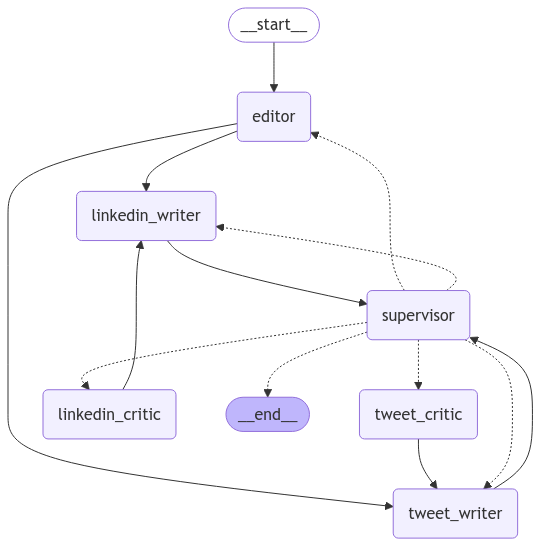

In [52]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [53]:
%%time
config = {"configurable": {"thread_id": 42}}

user_text = """
With 22 billion parameters, Mistral Small v24.09 offers customers a convenient mid-point between Mistral NeMo 12B and Mistral Large 2,
providing a cost-effective solution that can be deployed across various platforms and environments.
The new small model delivers significant improvements in human alignment, reasoning capabilities, and code over the previous model.

Mistral-Small-Instruct-2409 is an instruct fine-tuned version with the following characteristics:

- 22B parameters
- Vocabulary to 32768
- Supports function calling
- 128k sequence length

Mistral Small v24.09 is released under the MRL license. You may self-deploy it for non-commercial purposes, using e.g. vLLM

Weights on HuggingFace hub: https://huggingface.co/mistralai/Mistral-Small-Instruct-2409
"""

state = app.invoke(
    {
        "user_text": user_text,
        "target_audience": "AI/ML engineers and researchers, Data Scientists",
        "tweet": Post(drafts=[], feedback=None),
        "linkedin_post": Post(drafts=[], feedback=None),
        "n_drafts": 3,
    },
    config=config,
)



CPU times: user 361 ms, sys: 36 ms, total: 397 ms
Wall time: 44.6 s


In [54]:
print(state["tweet"].feedback)

Here are 3 specific suggestions to improve the tweet's engagement potential:

1. **Start with a stronger hook**: Instead of "Revolutionize your AI projects", consider "Unlock 22B parameters of AI power" to grab attention immediately.
2. **Make it more concise**: The tweet is a bit long; try to condense it to focus on the key benefits, such as "Cost-effective AI model with 22B parameters, improved human alignment, and function calling. Try Mistral Small v24.09 now!"
3. **Add a clear call-to-action**: While the tweet mentions trying the model, make it more explicit by adding "Share your projects" or "Get started now and let us know what you think" to encourage interaction and sharing.


In [56]:
import textwrap
for i, draft in enumerate(state["tweet"].drafts):
    print(f"Draft #{i+1}")
    print("-" * 10)
    print(textwrap.fill(draft, 80))
    print()

Draft #1
----------
Introducing Mistral Small v24.09, a cost-effective AI model with 22 billion
parameters that delivers significant improvements in human alignment, reasoning
capabilities, and code, making it a game-changer for AI/ML engineers and
researchers. This model offers a unique combination of performance and
flexibility, supporting function calling and a 128k sequence length. With its
release under the MRL license, you can self-deploy Mistral Small v24.09 for non-
commercial purposes and explore its capabilities.

Draft #2
----------
Revolutionize your AI projects with Mistral Small v24.09, a cost-effective model
that delivers significant improvements in human alignment, reasoning
capabilities, and code. With 22 billion parameters and support for function
calling, this model is a game-changer for AI/ML engineers and researchers,
offering unparalleled flexibility and performance. Try Mistral Small v24.09 now
and explore its capabilities under the MRL license for non-commercial

In [57]:
print(state["linkedin_post"].feedback)

### Hook
Assessment: The suggested LinkedIn post starts with a clear and concise statement about a breakthrough in AI deployment, which is likely to grab the attention of AI/ML engineers and researchers. However, it may not be as engaging as a more personalized or surprising opening.
Suggestion: Use a more thought-provoking or intriguing opening line that highlights the significance of the breakthrough.
Example: "Imagine deploying AI models without breaking the bank - our latest innovation, Mistral Small v24.09, makes this a reality with 22B parameters and enhanced human alignment."

### Structure
Assessment: The post is very concise, which is good for readability, but it lacks a clear flow of ideas and may leave readers wanting more information.
Suggestion: Expand the post to provide a brief overview of the benefits and features of Mistral Small v24.09, while still keeping it concise.
Example: "Breakthrough in AI Deployment: Introducing Mistral Small v24.09. This cost-effective soluti

In [58]:

for i, draft in enumerate(state["linkedin_post"].drafts):
    print(f"Draft #{i+1}")
    print("-" * 10)
    print(draft)
    print()


Draft #1
----------
Revolutionary AI Model Released
Solving deployment cost challenges, Mistral Small v24.09 offers:
* 22B parameters
* Enhanced human alignment
* Improved reasoning capabilities
Delivering a cost-effective solution, what projects will you deploy it on?

Draft #2
----------
Breakthrough in AI Deployment: Introducing Mistral Small v24.09. Solving deployment cost challenges, it offers:
* 22B parameters
* Enhanced human alignment
* Improved reasoning capabilities
What projects will you deploy it on?

Draft #3
----------
Breakthrough in AI Deployment: Introducing Mistral Small v24.09. This cost-effective solution offers 
* 22B parameters
* Enhanced human alignment
* Improved reasoning capabilities, making it perfect for deployment in various projects. What projects will you deploy it on?

